# <center> Проект: классификация

In [1]:
# игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

# для анализа данных
import pandas as pd
import numpy as np

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# для машинного обучения
from sklearn import linear_model as lm
from sklearn import tree as t
from sklearn import ensemble as ens
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import model_selection as ms 
from sklearn import feature_selection as fs

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Данные о клиентах банка:
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [2]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')

df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


### Пропуски

In [3]:
# исследуем данные на предмет пропусков
df.isna().sum() 

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

> Пропуски помечены словом "unknown", они есть в столбцах `job, education, balance, contact, poutcome`.

In [4]:
# преобразуем признак "balance" таким образом, чтобы он корректно считывался, как вещественное число (float)
# обрабатываем пропуски, заменив их на медианные значения по данному признаку

df['balance'] = df['balance'].apply(lambda b: b.replace(' ', '').replace(',', '.')[:-1] 
                                    if b is not np.nan 
                                    else None).astype('float')

df['balance'] = df['balance'].fillna(df['balance'].median())

df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [5]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
job_mode = df['job'].mode().values[0]
ed_mode = df['education'].mode().values[0]

df['job'] = df['job'].apply(lambda j: job_mode if j == 'unknown' else j)
df['education'] = df['education'].apply(lambda ed: ed_mode if ed == 'unknown' else ed)

df[['job', 'education']] 

,job,education
0,admin.,secondary
1,admin.,secondary
2,technician,secondary
3,services,secondary
4,admin.,tertiary
...,...,...
11157,blue-collar,primary
11158,services,secondary
11159,technician,secondary
11160,technician,secondary


### Выбросы

In [6]:
# удалим все выбросы для признака "balance"
def find_outliers_iqr(data, 
                      feature, 
                      left=1.5, 
                      right=1.5, 
                      log_scale=False):
    """Находит выбросы в данных, используя метод межквартильного размаха."""
    
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
        
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    
    return outliers, cleaned

df = find_outliers_iqr(df, 'balance')[1]

df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

<AxesSubplot: xlabel='index', ylabel='deposit'>

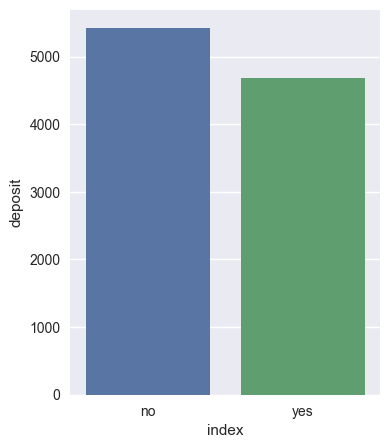

In [7]:
# изучим соотношение классов в наших данных на предмет несбалансированности
deposit_df = pd.DataFrame(df['deposit'].value_counts()).reset_index()

plt.figure(figsize=(4, 5))
sns.barplot(deposit_df, x='index', y='deposit') 

> Классы относительно сбалансированы.

In [8]:
# рассчитаем описательные статистики для числовых переменных
df[['age', 'balance', 'duration', 'campaign']].describe() 

,age,balance,duration,campaign
count,10104.000000,10104.000000,10104.000000,10104.000000
mean,40.895487,807.331354,368.777712,2.516924
std,11.735511,993.673452,346.650712,2.707180
min,18.000000,-2049.000000,2.000000,1.000000
25%,32.000000,95.000000,137.000000,1.000000
50%,38.000000,444.500000,252.000000,2.000000
75%,48.000000,1224.750000,490.000000,3.000000
max,95.000000,4062.000000,3881.000000,43.000000


<AxesSubplot: xlabel='campaign', ylabel='count'>

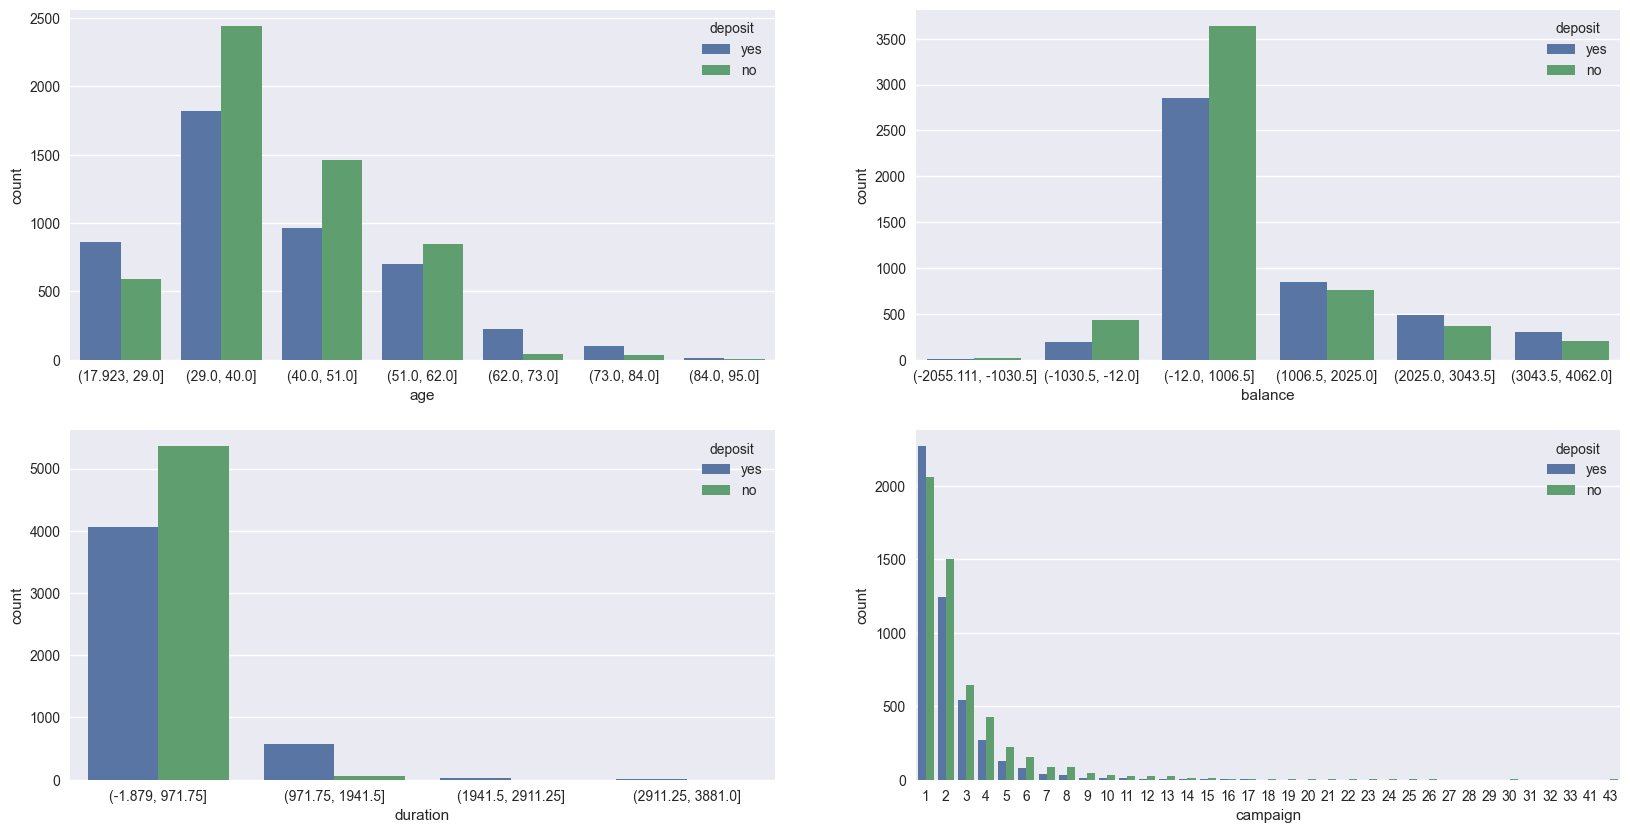

In [9]:
# построим визуализации, иллюстрирующие результаты
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

age_dep = pd.concat([pd.cut(df['age'], 7), df['deposit']], axis=1)
sns.countplot(age_dep, x='age', hue='deposit', ax=ax[0, 0])

bal_dep = pd.concat([pd.cut(df['balance'], 6), df['deposit']], axis=1)
sns.countplot(bal_dep, x='balance', hue='deposit', ax=ax[0, 1])

dur_dep = pd.concat([pd.cut(df['duration'], 4), df['deposit']], axis=1)
sns.countplot(dur_dep, x='duration', hue='deposit', ax=ax[1, 0]) 

cam_dep = df[['campaign', 'deposit']]
sns.countplot(cam_dep, x='campaign', hue='deposit', ax=ax[1, 1]) 

> Депозиты с большей вероятностью оформляют студенты и пенсионеры, люди с высоким балансом, у которых была малая продолжительность контакта и всего одна кампания.

In [10]:
# рассчитаем описательные статистики для категориальных переменных
df[['job', 'marital', 'education', 
    'default', 'housing', 'loan', 
    'contact', 'month', 'poutcome']].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10104,10104,10104,10104,10104,10104,10104,10104,10104
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2314,5714,5517,9938,5243,8711,7282,2616,7570


<AxesSubplot: xlabel='education', ylabel='count'>

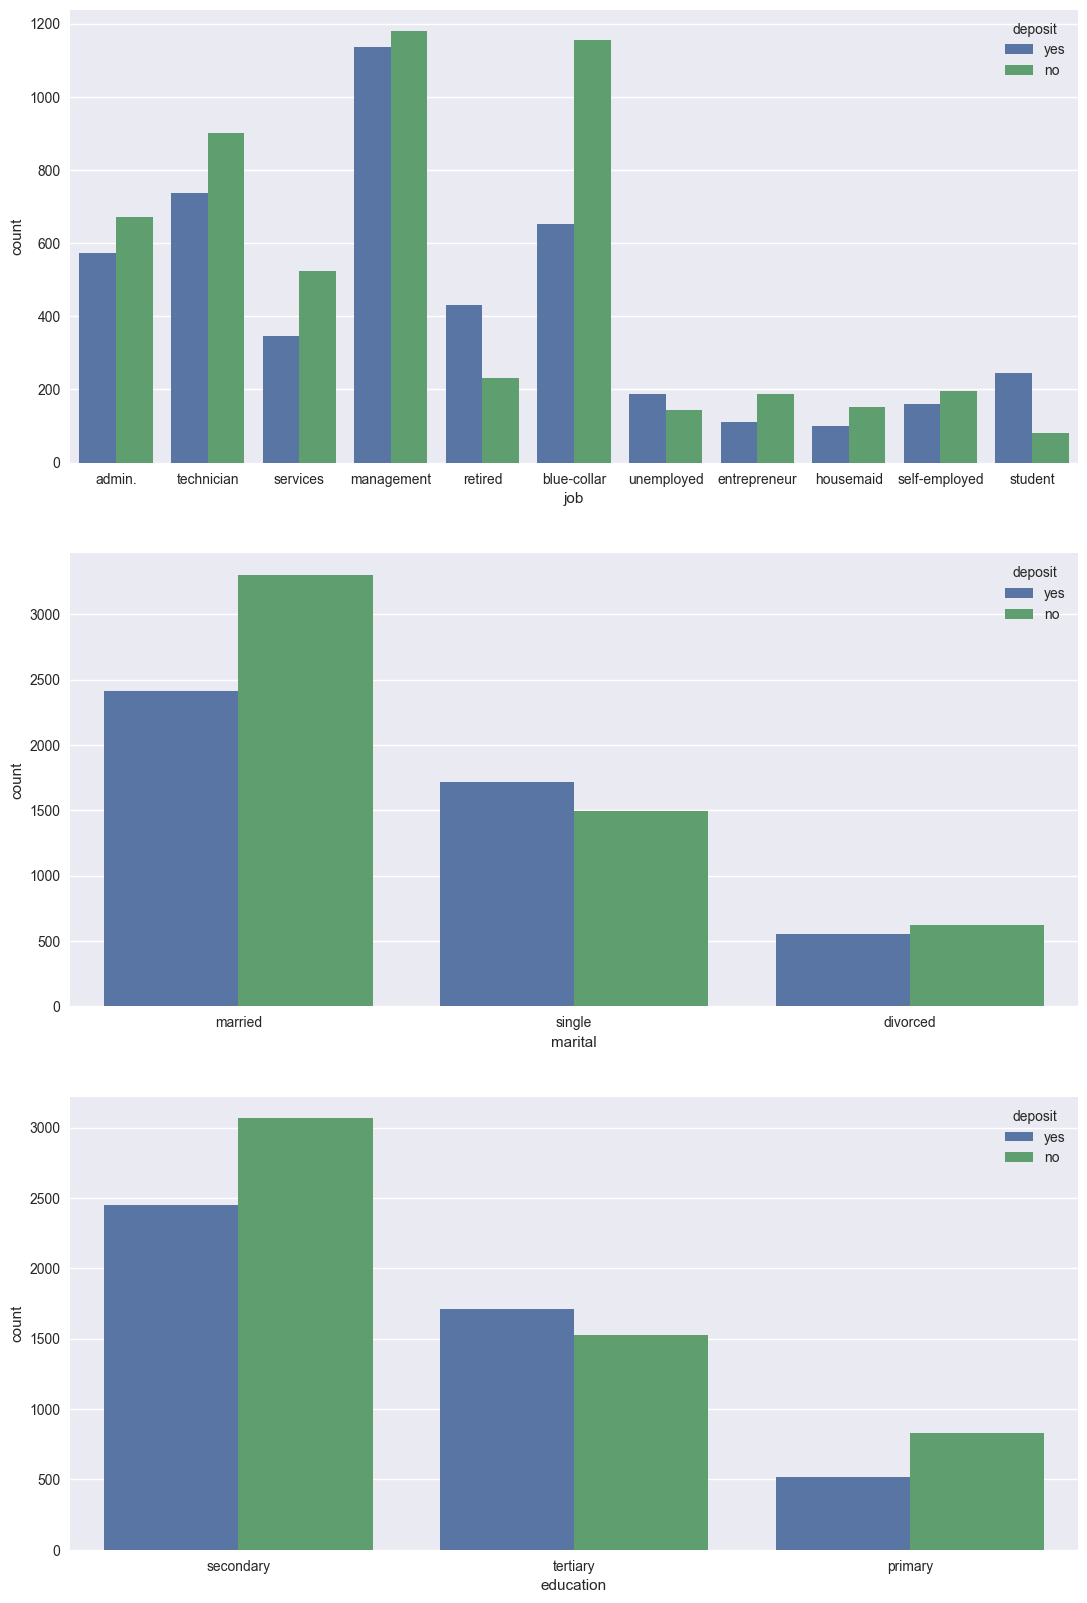

In [11]:
# построим визуализации, иллюстрирующие результаты
fig, ax = plt.subplots(3, 1, figsize=(13, 20))

sns.countplot(df, x='job', hue='deposit', ax=ax[0])
sns.countplot(df, x='marital', hue='deposit', ax=ax[1])
sns.countplot(df, x='education', hue='deposit', ax=ax[2])

<AxesSubplot: xlabel='poutcome', ylabel='count'>

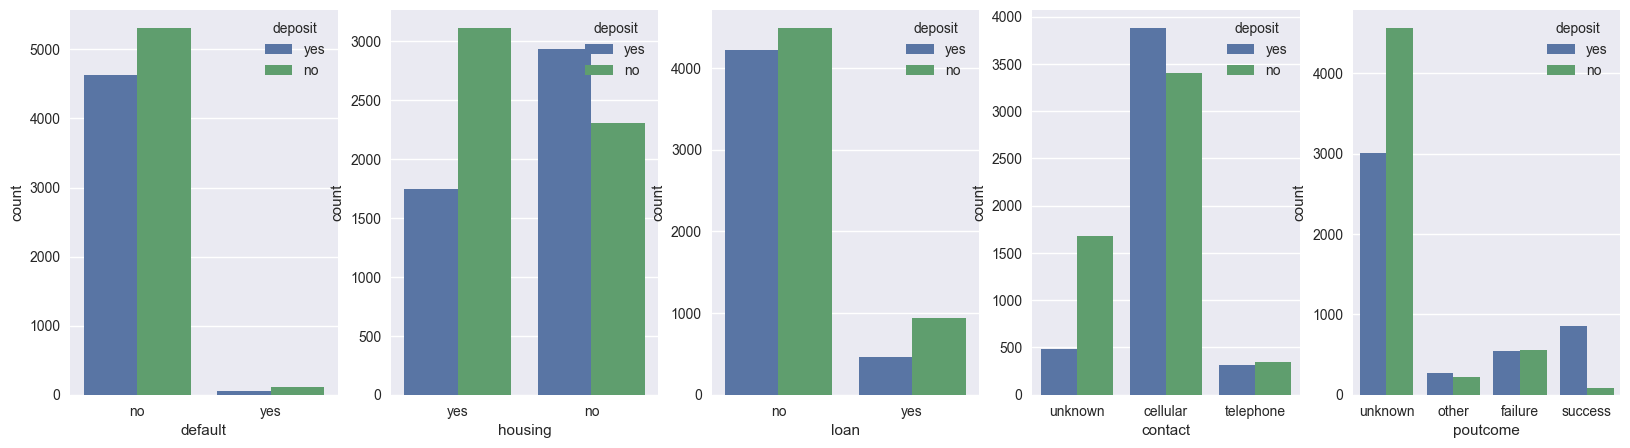

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

sns.countplot(df, x='default', hue='deposit', ax=ax[0])
sns.countplot(df, x='housing', hue='deposit', ax=ax[1])
sns.countplot(df, x='loan', hue='deposit', ax=ax[2])
sns.countplot(df, x='contact', hue='deposit', ax=ax[3])
sns.countplot(df, x='poutcome', hue='deposit', ax=ax[4])

> Здесь также, депозиты больше оформляют пенсионеры, студенты и безработные, одинокие люди, с высшим образованием, не оформлявшие кредит на жилье и те, с которыми был контакт по сотовой связи. Столбец о результатах кампании мало о чем говорит из-за большого количества пропусков.

<AxesSubplot: xlabel='poutcome', ylabel='count'>

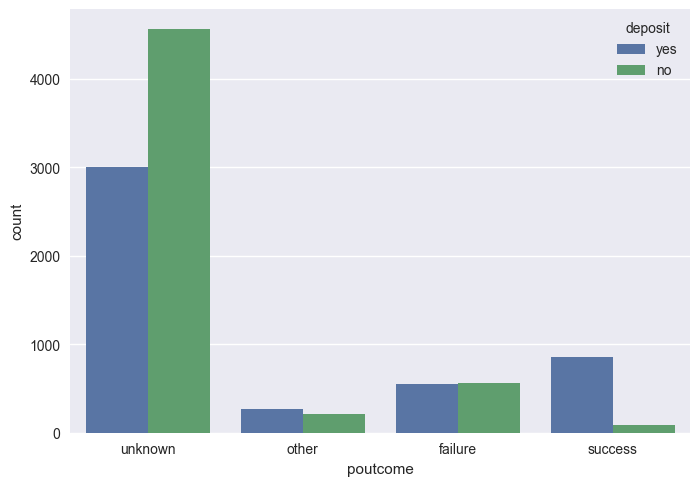

In [13]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач
sns.countplot(df, x='poutcome', hue='deposit') 

> Несмотря на много пропусков, можно сказать, что если в предыдущей кампании был успех, то и в текущей будет успех с большей вероятностью.

<AxesSubplot: xlabel='month', ylabel='count'>

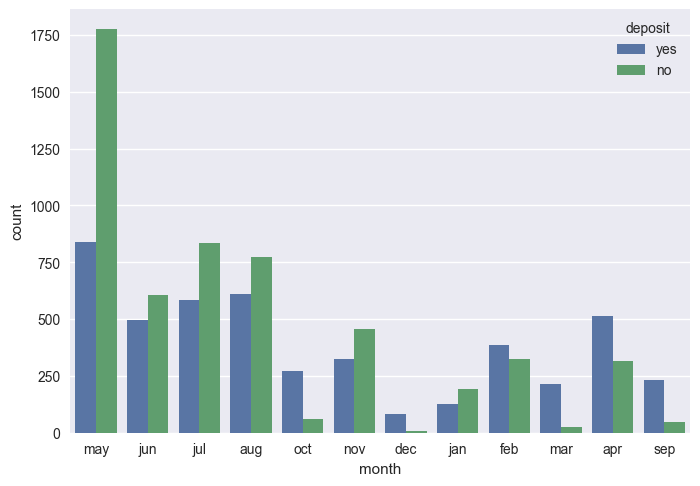

In [14]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
sns.countplot(df, x='month', hue='deposit')

> Чаще всего отказов происходит именно в мае. Это вероятно связано с тем, что в мае люди чаще уходят в отпуск и им нужно тратить деньги, а не вкладывать.

<AxesSubplot: xlabel='age', ylabel='count'>

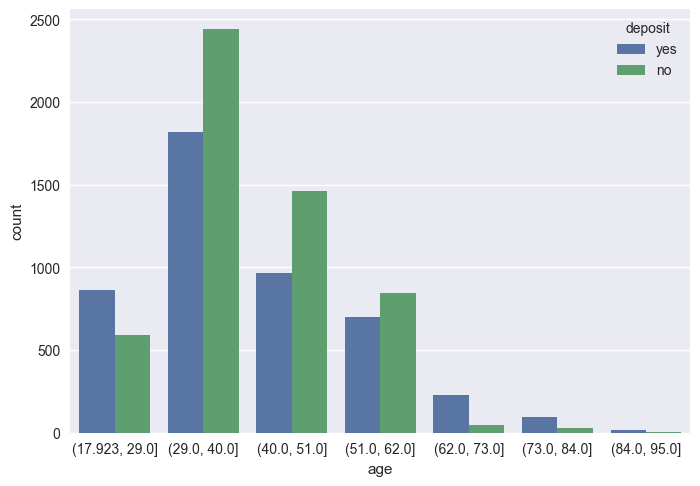

In [15]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
age_dep = pd.concat([pd.cut(df['age'], 7), df['deposit']], axis=1)

sns.countplot(age_dep, x='age', hue='deposit')

> Депозит чаще всего открывают до 30 и от 60. Первые это делают, потому что у них маленький зароботок или вообще его нет, а вторые - вероятно, чтобы накопить состояние в наследство, если размер самой пенсии достаточный.

<AxesSubplot: xlabel='marital', ylabel='count'>

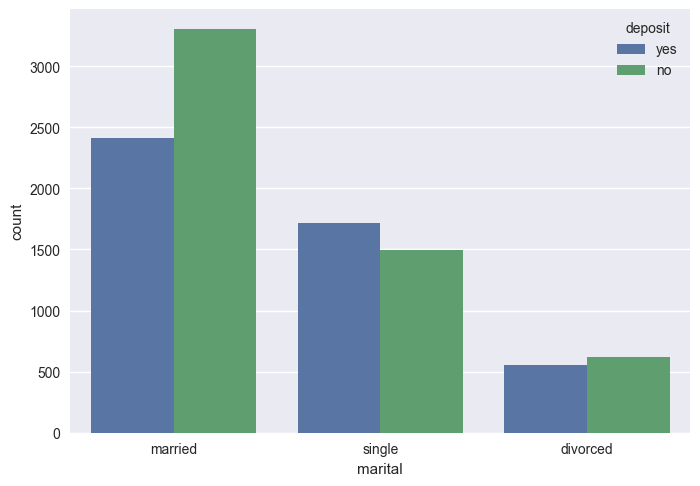

In [16]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(df, x='marital', hue='deposit')

> Депозит открывают с большей вероятностью одинокие люди, так как живя одному тоже трудно заработать большую сумму.

<AxesSubplot: xlabel='education', ylabel='count'>

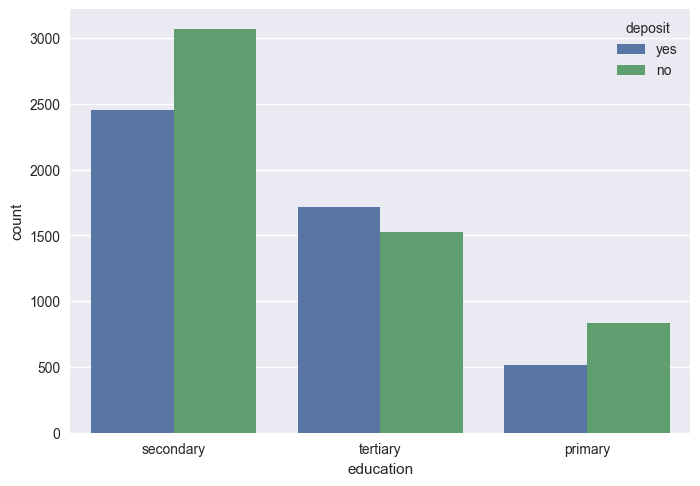

In [17]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(df, x='education', hue='deposit')

> На открытие счета чаще всего соглашаются люди с высшим образованием, так как ими и являются студенты (получающие его) и пенсионеры.

<AxesSubplot: xlabel='job', ylabel='count'>

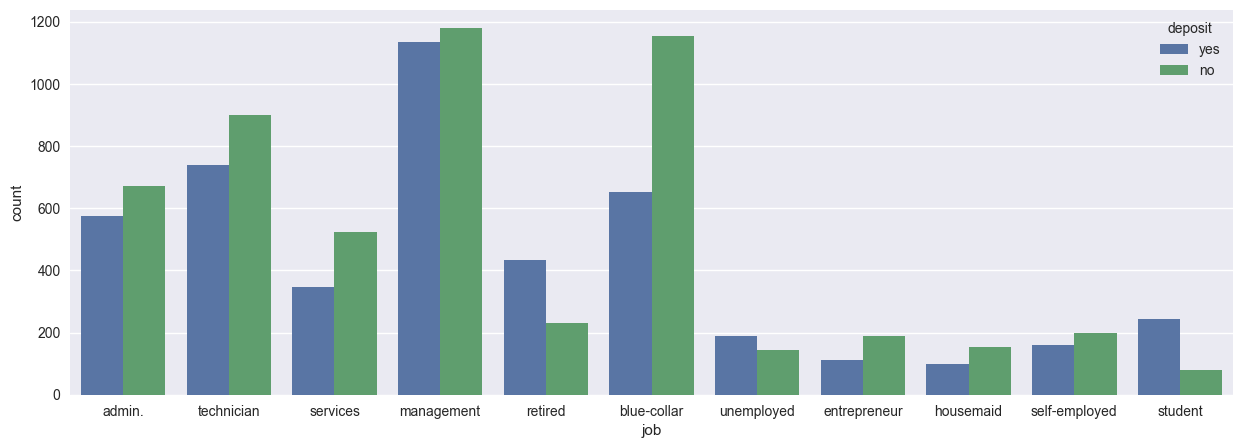

In [18]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure(figsize=(15, 5))
sns.countplot(df, x='job', hue='deposit')

> График снова подтверждает, что депозиты нужны студентам, пенсионерам и безработным. То есть к открытию депозита людей толкает как правило низкий уровень дохода.

In [19]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны, 
# если рассматривать тех, кто открыл депозит

mat_edc_df = df.groupby(['deposit', 
                         'marital', 
                         'education'])['deposit'].count().reset_index(name='cnt')
 
mat_edc_df.sort_values('cnt', ascending=False)

,deposit,marital,education,cnt
4,no,married,secondary,1830
13,yes,married,secondary,1289
16,yes,single,secondary,879
7,no,single,secondary,866
5,no,married,tertiary,831
14,yes,married,tertiary,784
17,yes,single,tertiary,755
3,no,married,primary,641
8,no,single,tertiary,531
1,no,divorced,secondary,370


> Наиболее часто встречаются (причем среди открывших и не открывших депозит) люди в браке со среднешкольным образованием.

## Часть 3: Преобразование данных

In [20]:
# преобразуем уровни образования
le = pp.LabelEncoder()

df['education'] = le.fit_transform(df['education'])

df['education']

0        1
1        1
2        1
3        1
4        2
        ..
11157    0
11158    1
11159    1
11160    1
11161    1
Name: education, Length: 10104, dtype: int32

In [21]:
# преобразуем бинарные переменные в представление из нулей и единиц
binar = lambda x: 1 if x == 'yes' else 0

df_bins = ['default', 'housing', 'loan', 'deposit']

for col in df_bins:
    df[col] = df[col].apply(binar)
    
df[df_bins]

,default,housing,loan,deposit
0,0,1,0,1
1,0,0,0,1
2,0,1,0,1
3,0,1,0,1
4,0,0,0,1
...,...,...,...,...
11157,0,1,0,0
11158,0,0,0,0
11159,0,0,0,0
11160,0,0,1,0


In [22]:
# создадим дамми-переменные
df = pd.get_dummies(df)

df

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,39,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,32,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,43,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


<AxesSubplot: >

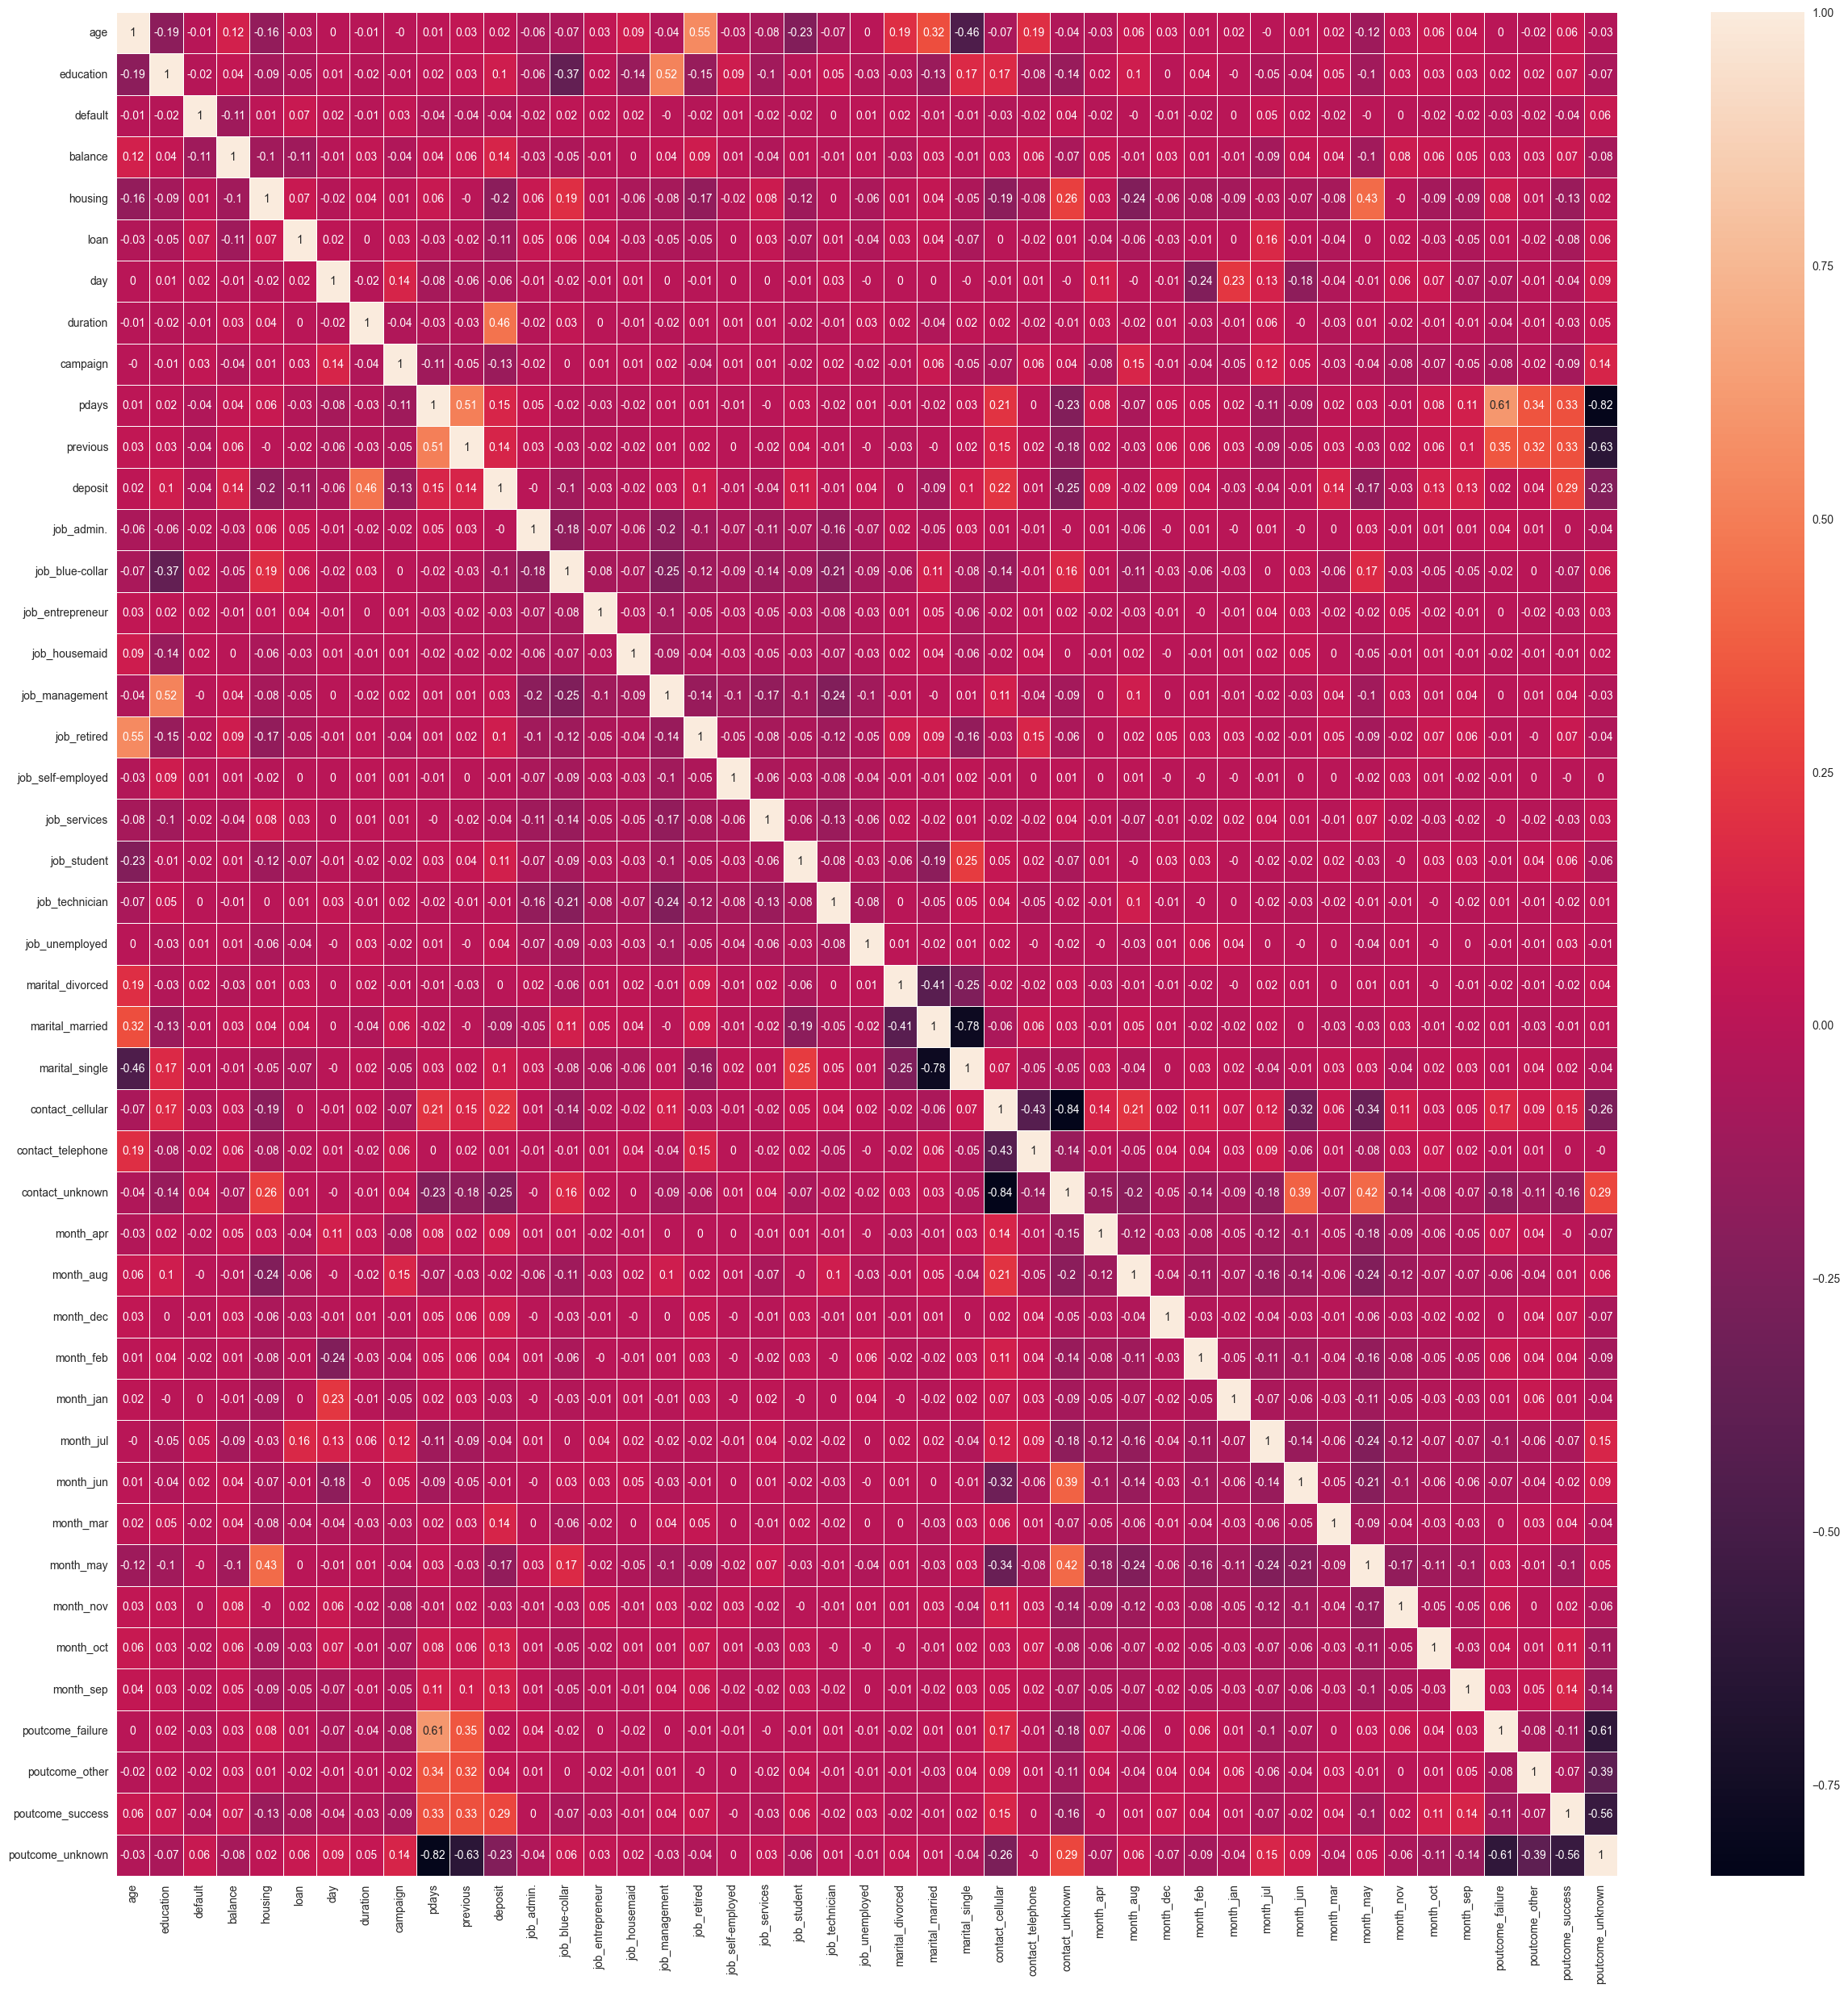

In [23]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
df_corr = df.corr().round(2)

plt.figure(figsize=(30, 30))
sns.heatmap(df_corr, annot=True, linewidths=.5)

> Если считать уровень корреляции выше |0.9| мультиколлинеарностью, то таких признаков нет.

<AxesSubplot: >

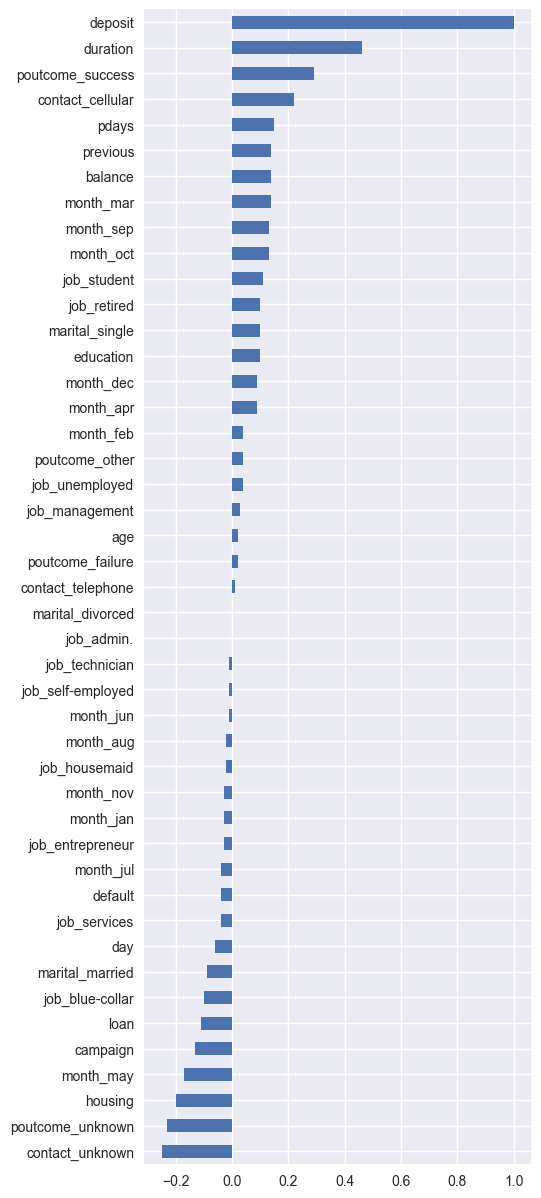

In [24]:
# посмотрим, какие признаки больше всего коррелируют с признаком открытия счета
deposit_corr = df_corr['deposit'].sort_values()

plt.figure(figsize=(5, 15))
deposit_corr.plot(kind = 'barh')

> С признаком депозита больше всего коррелируют признаки (в порядке убывания) `duration, poutcome_success, contact_cellular`. 

In [25]:
# разделим данные на предикторы и целевой признак, а их уже на обучающую и проверочную выборки.
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [26]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков
skb = fs.SelectKBest(score_func=fs.f_classif, k=15)
skb.fit(X_train, y_train)

skb_feats = skb.get_feature_names_out()

X_train = X_train[skb_feats]
X_test = X_test[skb_feats]

skb_feats

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [27]:
# нормализуем данные с помощью minmaxscaler
mm_scaler = pp.MinMaxScaler()
mm_scaler.fit(X_train, y_train)

X_train_ = pd.DataFrame(mm_scaler.transform(X_train), columns=X_train.columns)
X_test_ = pd.DataFrame(mm_scaler.transform(X_test), columns=X_test.columns)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [28]:
# обучим логистическую регрессию и рассчитаем метрики качества
lr = lm.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
lr.fit(X_train_, y_train)

y_pred_train = lr.predict(X_train_)
y_pred_test = lr.predict(X_test_)

lr_acctrain = m.accuracy_score(y_train, y_pred_train)
lr_acctest = m.accuracy_score(y_test, y_pred_test)

round(lr_acctrain, 2), round(lr_acctest, 2)

(0.82, 0.81)

> Для начала неплохо, показатели метрик слабо различаются и предсказывают данные на хорошем уровне.

In [29]:
# обучим решающие деревья
tr = t.DecisionTreeClassifier(criterion='entropy', random_state=42)
tr.fit(X_train_, y_train)

y_pred_train = tr.predict(X_train_)
y_pred_test = tr.predict(X_test_)

lr_acctrain = m.accuracy_score(y_train, y_pred_train)
lr_acctest = m.accuracy_score(y_test, y_pred_test)

round(lr_acctrain, 2), round(lr_acctest, 2)

(1.0, 0.75)

> Здесь мы наблюдаем переобучение модели из-за того, что мы не выставили максимальную глубину дерева.

In [30]:
# подберем оптимальную глубину дерева от 1 до 10 и посмотрим на значения метрик
for d in range(1, 11):
    tr = t.DecisionTreeClassifier(criterion='entropy', 
                                  random_state=42, 
                                  max_depth=d)
    tr.fit(X_train_, y_train)

    y_pred_train = tr.predict(X_train_)
    y_pred_test = tr.predict(X_test_)

    lr_acctrain = m.accuracy_score(y_train, y_pred_train)
    lr_acctest = m.accuracy_score(y_test, y_pred_test)

    print(d, '->', round(lr_acctrain, 3), '/', round(lr_acctest, 3))

1 -> 0.709 / 0.71
2 -> 0.727 / 0.721
3 -> 0.775 / 0.77
4 -> 0.776 / 0.77
5 -> 0.803 / 0.797
6 -> 0.815 / 0.805
7 -> 0.822 / 0.804
8 -> 0.832 / 0.799
9 -> 0.84 / 0.793
10 -> 0.853 / 0.802


> Максимальная глубина дерева, при которой значение метрики на тестовой выборке наибольшее - это 6.

In [31]:
# обучим решающие деревья, настроим максимальную глубину
tr = t.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
tr.fit(X_train_, y_train)

y_pred_train = tr.predict(X_train_)
y_pred_test = tr.predict(X_test_)

lr_acctrain = m.accuracy_score(y_train, y_pred_train)
lr_acctest = m.accuracy_score(y_test, y_pred_test)

round(lr_acctrain, 2), round(lr_acctest, 2)

(0.81, 0.8)

> Вот теперь показатели более реалистичные и переобучения не наблюдается.

In [32]:
# подберем оптимальные параметры с помощью gridsearch
paramparam = {'min_samples_split': [2, 5, 7, 10], 
              'max_depth': [3, 5, 7]}

gs = ms.GridSearchCV(estimator=t.DecisionTreeClassifier(criterion='entropy', random_state=42), 
                     param_grid=paramparam, 
                     scoring='f1')
gs.fit(X_train_, y_train)

print(f"Лучшие параметры - {gs.best_params_}", '\n'
      f"F1-score на тестовой выборке - {round(gs.score(X_test_, y_test), 3)}")

Лучшие параметры - {'max_depth': 5, 'min_samples_split': 2} 
F1-score на тестовой выборке - 0.784


> Лучшая модель, по мнению "сетки", - это решающее дерево с максимальеой глубиной 5 и максимальным количеством выборок, на которые делится вершина дерева, - равным 2. 

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [33]:
# обучим на наших данных случайный лес
rf = ens.RandomForestClassifier(n_estimators = 100,
                                criterion = 'gini',
                                min_samples_leaf = 5,
                                max_depth = 10,
                                random_state = 42)
rf.fit(X_train_, y_train)

y_pred_test = rf.predict(X_test_)

round(m.accuracy_score(y_test, y_pred_test), 2), round(m.recall_score(y_test, y_pred_test), 2)

(0.83, 0.84)

> Значения метрик `accuracy` и `recall` примерно равны друг другу и ненамного отличаются от предыдущих результатов. То есть случайный лес также хорошо справляется с задачей классификации, как и логистическая регрессия и дерево решений.

In [34]:
# используем для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ens.GradientBoostingClassifier(learning_rate = 0.05,
                                    n_estimators = 300,
                                    min_samples_leaf = 5,
                                    max_depth = 5,
                                    random_state = 42)
gb.fit(X_train_, y_train)

y_pred_test = rf.predict(X_test_)

print(m.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



> Модель градиентного бустинга не показала повышенной эффективности в предсказывании классов.

In [35]:
# объединим уже известные вам алгоритмы с помощью стекинга 
sc = ens.StackingClassifier(estimators=[('tr', tr), ('lr', lr), ('gb', gb)], 
                            final_estimator=lr)
sc.fit(X_train_, y_train)

y_pred_test = rf.predict(X_test_)

print(m.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



> Стекинг предсказывает классы с такой же эффективностью, как и остальные созданные нами модели.

In [36]:
# оценим, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга
sc_gb = sc.named_estimators['gb']

pd.Series(data=sc_gb.feature_importances_, 
          index=sc_gb.feature_names_in_).sort_values(ascending=False)

duration            0.514129
poutcome_success    0.119465
contact_unknown     0.080584
balance             0.063823
pdays               0.053574
housing             0.050888
month_mar           0.026951
month_oct           0.018953
campaign            0.018890
month_sep           0.014608
month_may           0.013534
loan                0.012659
previous            0.008371
contact_cellular    0.002903
poutcome_unknown    0.000668
dtype: float64

> Удивительно, но первые 2 признака - это те же самые 2 признака из 3, что сильнее всего коррелируют с целевой переменной - это длительность разговора с клиентом и успешность предыдущей рекламной компании. Значит именно они оказывают наибольшее влияние на то, оформит ли человек депозит в банке или нет.

In [37]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
import optuna
from optuna.trial import Trial

def optuna_rf(trial: Trial):
    """Функция для рассчета параметров для оптимизации модели (случайного леса). 
       Она предлагает разные диапазоны значений параметров модели, 
       обучает её и возвращает значение метрики (F1)"""
    
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    rf = ens.RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=42)
    
    rf.fit(X_train_, y_train)
    
    score = m.f1_score(y_test, rf.predict(X_test_))

    return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

y_test_pred = rf.predict(X_test_)

print("")
print(f"Лучшие параметры - {study.best_params}", '\n', 
      f"F1-score на тестовой выборке - {round(m.f1_score(y_test, y_test_pred), 3)}", '\n', 
      f"Accuracy на тестовой выборке - {round(m.accuracy_score(y_test, y_test_pred), 3)}")

[I 2023-05-05 20:00:31,523] A new study created in memory with name: RandomForestClassifier
[I 2023-05-05 20:00:32,025] Trial 0 finished with value: 0.8211586901763225 and parameters: {'n_estimators': 127, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8211586901763225.
[I 2023-05-05 20:00:32,482] Trial 1 finished with value: 0.815540113708149 and parameters: {'n_estimators': 105, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8211586901763225.
[I 2023-05-05 20:00:33,355] Trial 2 finished with value: 0.818639798488665 and parameters: {'n_estimators': 198, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8211586901763225.
[I 2023-05-05 20:00:33,975] Trial 3 finished with value: 0.8157977883096367 and parameters: {'n_estimators': 152, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8211586901763225.
[I 2023-05-05 20:00:34,483] Trial 4 finished with value: 0.8211586901763225 and parameters: {'n_e


Лучшие параметры - {'n_estimators': 189, 'max_depth': 13, 'min_samples_leaf': 3} 
 F1-score на тестовой выборке - 0.821 
 Accuracy на тестовой выборке - 0.831


> Optuna показала, что лучшее количество деревьев - 167, максимальная глубина дерева - 13, а минимальное количество объектов в листе - 2. Однако метрики находятся в том же диапазоне, что и раньше - от 0.81 до 0.84.